## UKBB Exploratory Data Analysis

### Imports

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from env.imports import *

In [6]:
from models import *
from data import * 
from env import *
from sim import *

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome


In [7]:
# Set paths
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
UKBB_demographics.head()

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/


,MRID,Age,IsF,Race
0,1000038_2_0,64.64,1.0,British
1,1000108_2_0,68.39,0.0,British
2,1000149_2_0,76.67,0.0,Irish
3,1000201_2_0,67.24,1.0,British
4,1000213_2_0,67.73,1.0,British


### Demographics

Number of unique subjects: 1959


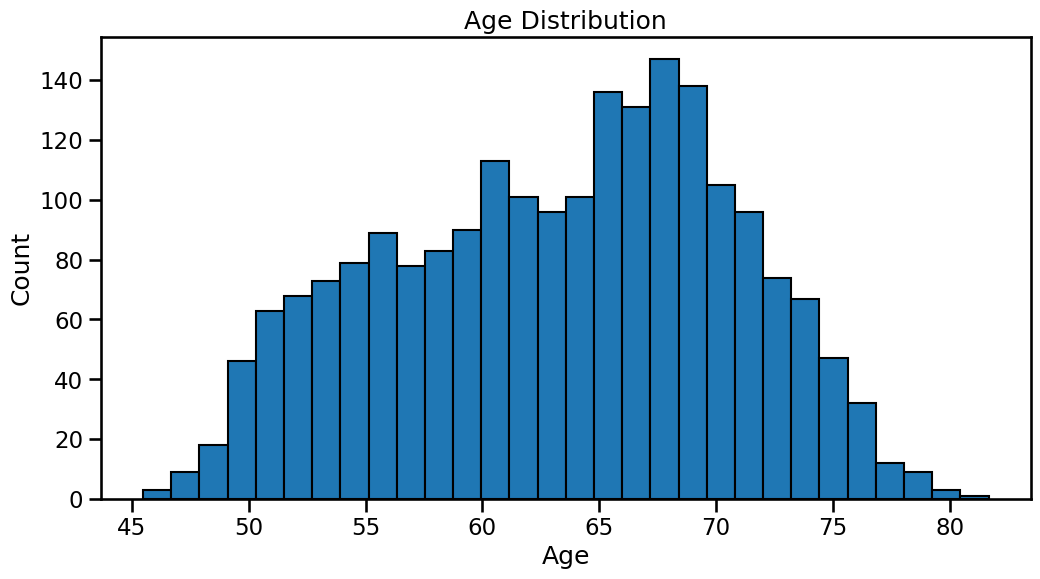

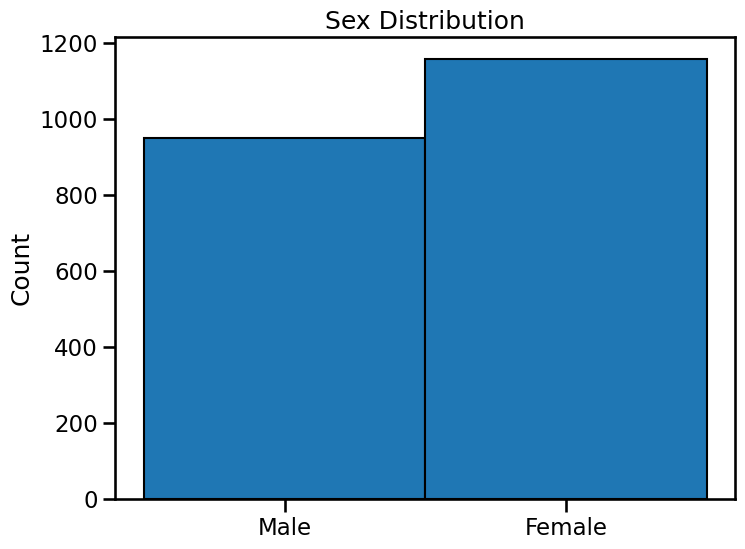

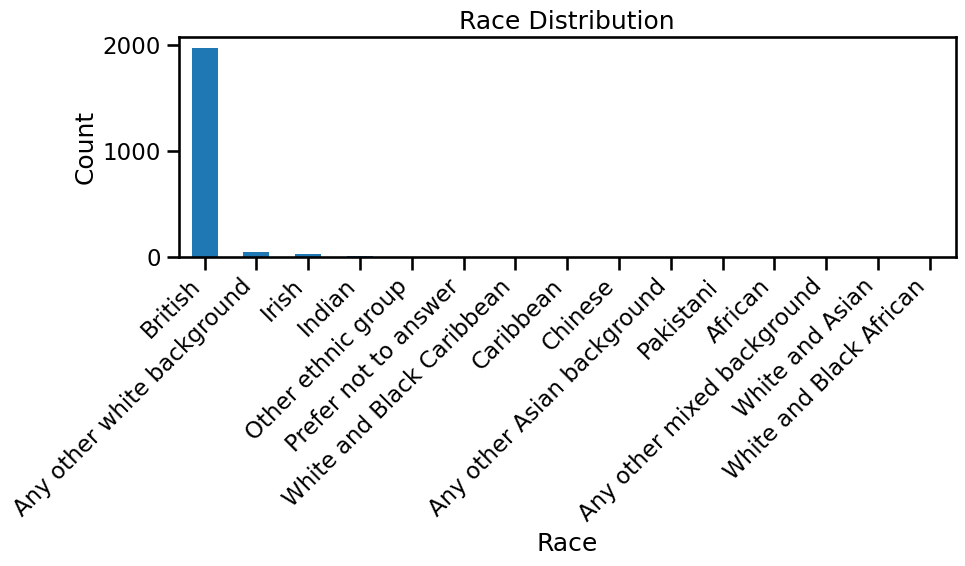

In [8]:
unique_subject_ids = list(set([x.split('-')[1] for x in os.listdir(UKBB_path + '/XCP_D/') if x.startswith('sub-')]))
print(f"Number of unique subjects: {len(unique_subject_ids)}")

# Age histogram
plt.figure(figsize=(12, 6))
plt.hist(UKBB_demographics['Age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Sex histogram
plt.figure(figsize=(8, 6))
plt.hist(UKBB_demographics['IsF'], bins=2, edgecolor='black')
plt.title('Sex Distribution')
plt.ylabel('Count')
plt.xticks([0.25, 0.75], ['Male', 'Female'], ha='center')  # Center x-axis labels under bars
plt.show()

# Race histogram
plt.figure(figsize=(10, 6))
UKBB_demographics['Race'].value_counts().plot(kind='bar')
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Display a sample subject's connectome

Selected subject: 1083837
Full path to relmat: /scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1083837/ses-20227/func/sub-1083837_ses-20227_task-rest_space-MNI152NLin6Asym_seg-4S156Parcels_stat-pearsoncorrelation_relmat.tsv


Text(0.5, 1.0, 'Connectivity Matrix')

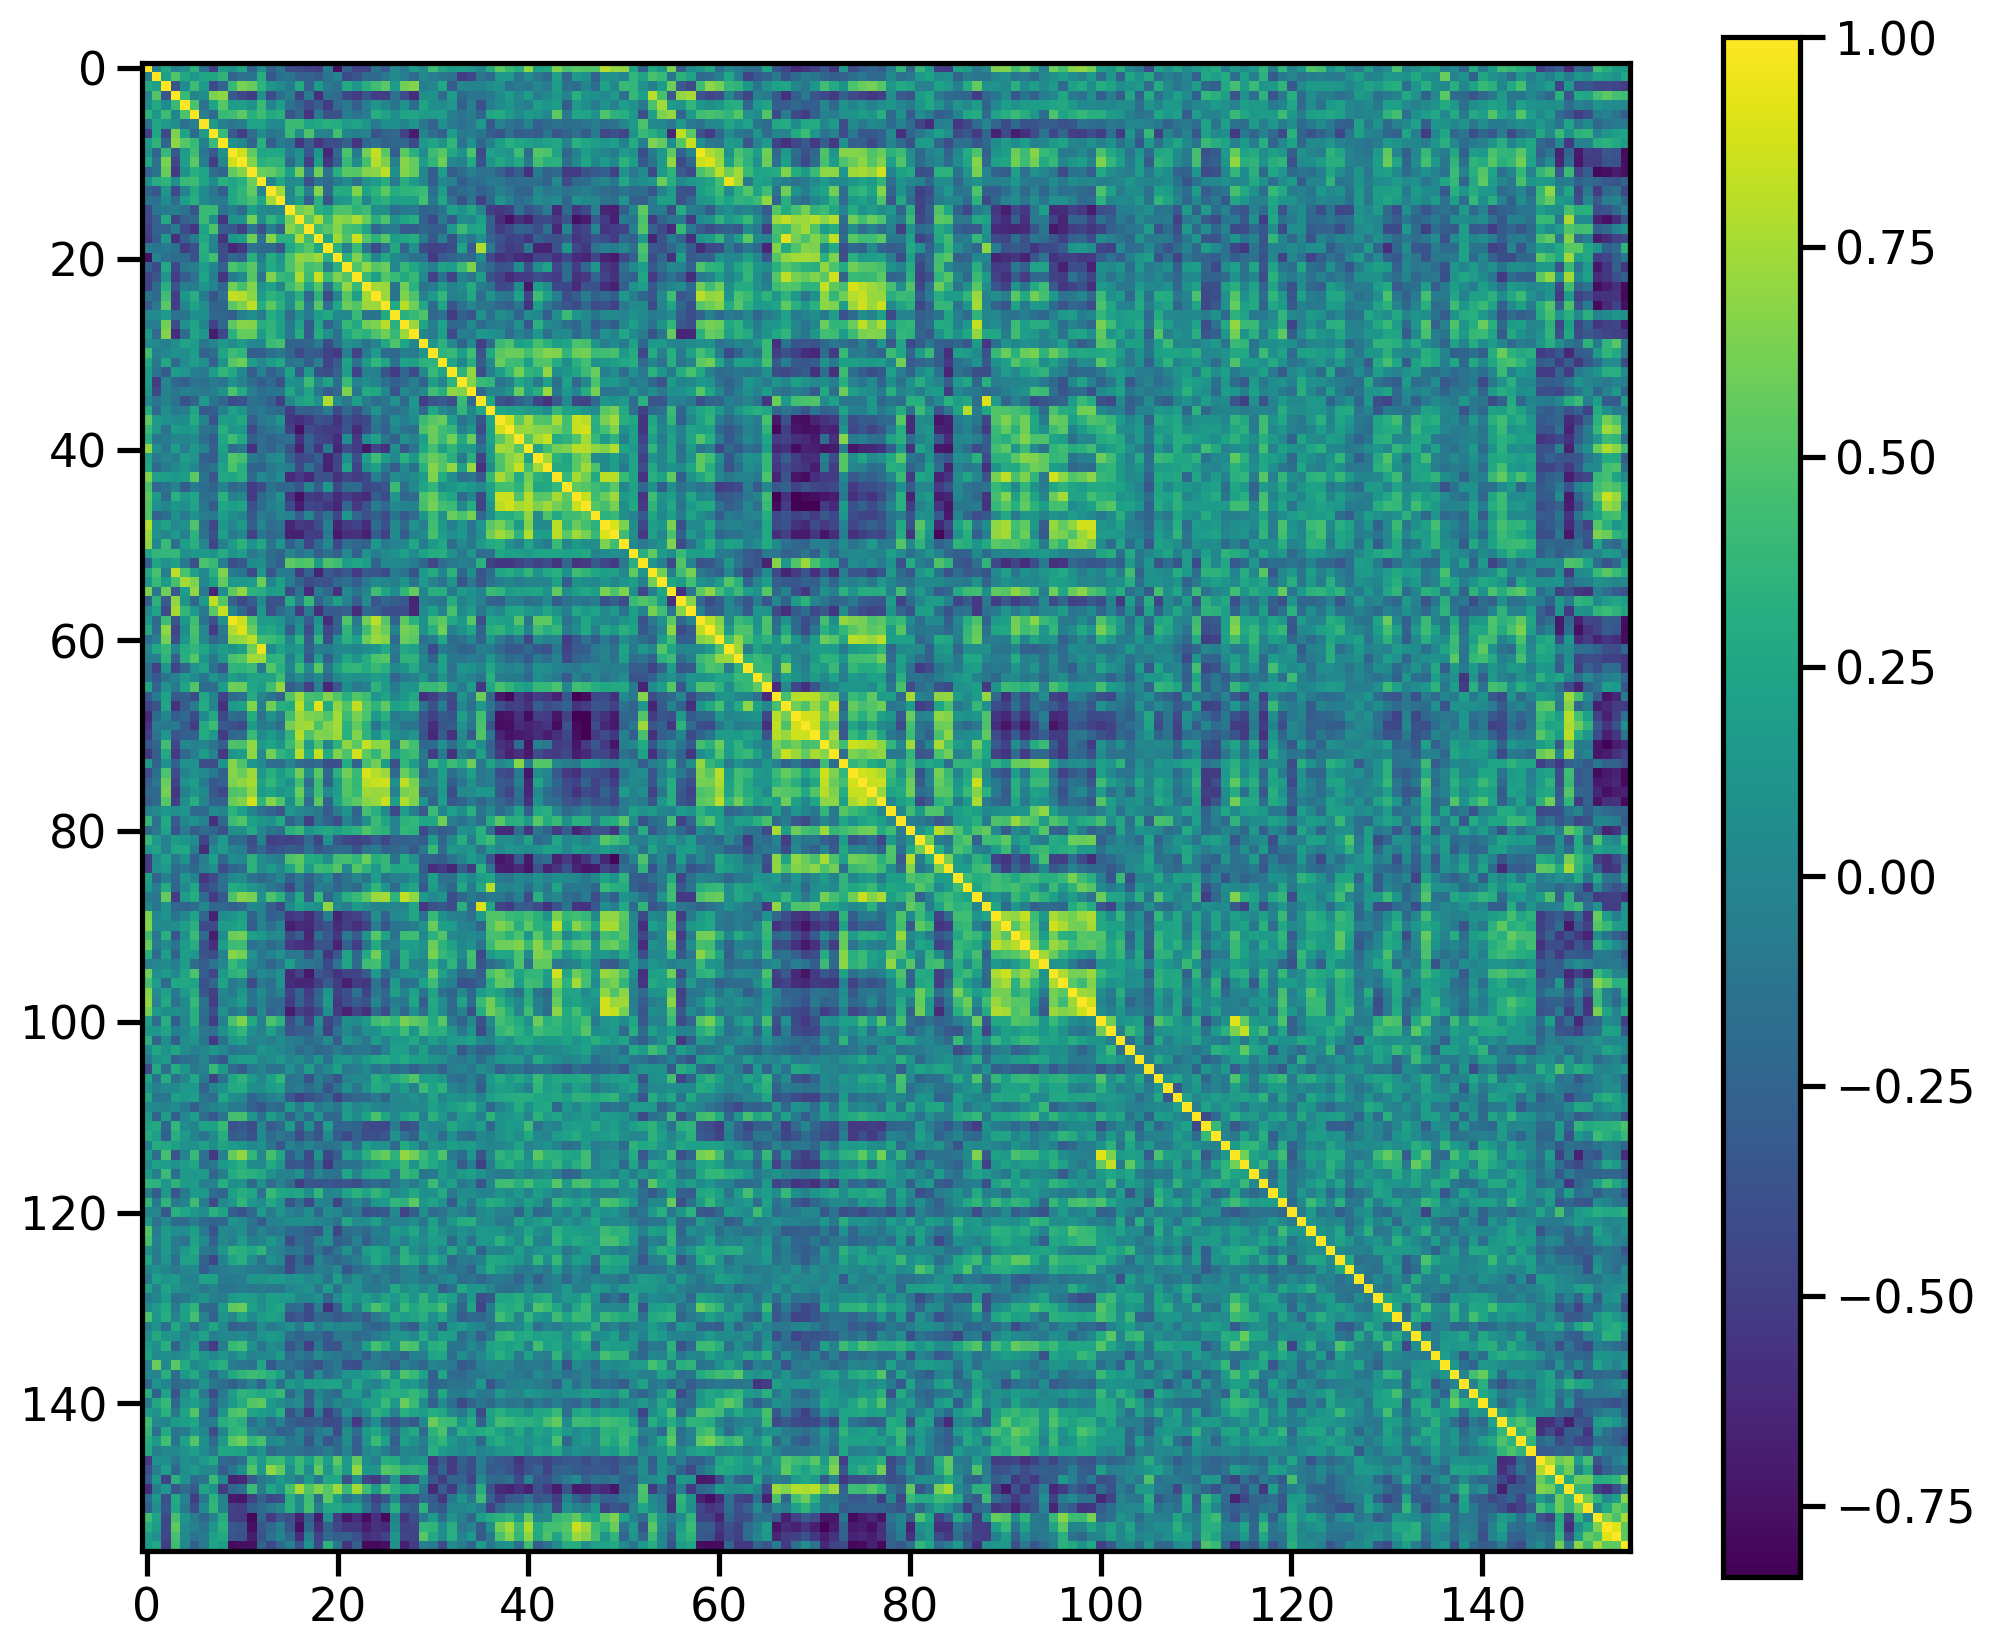

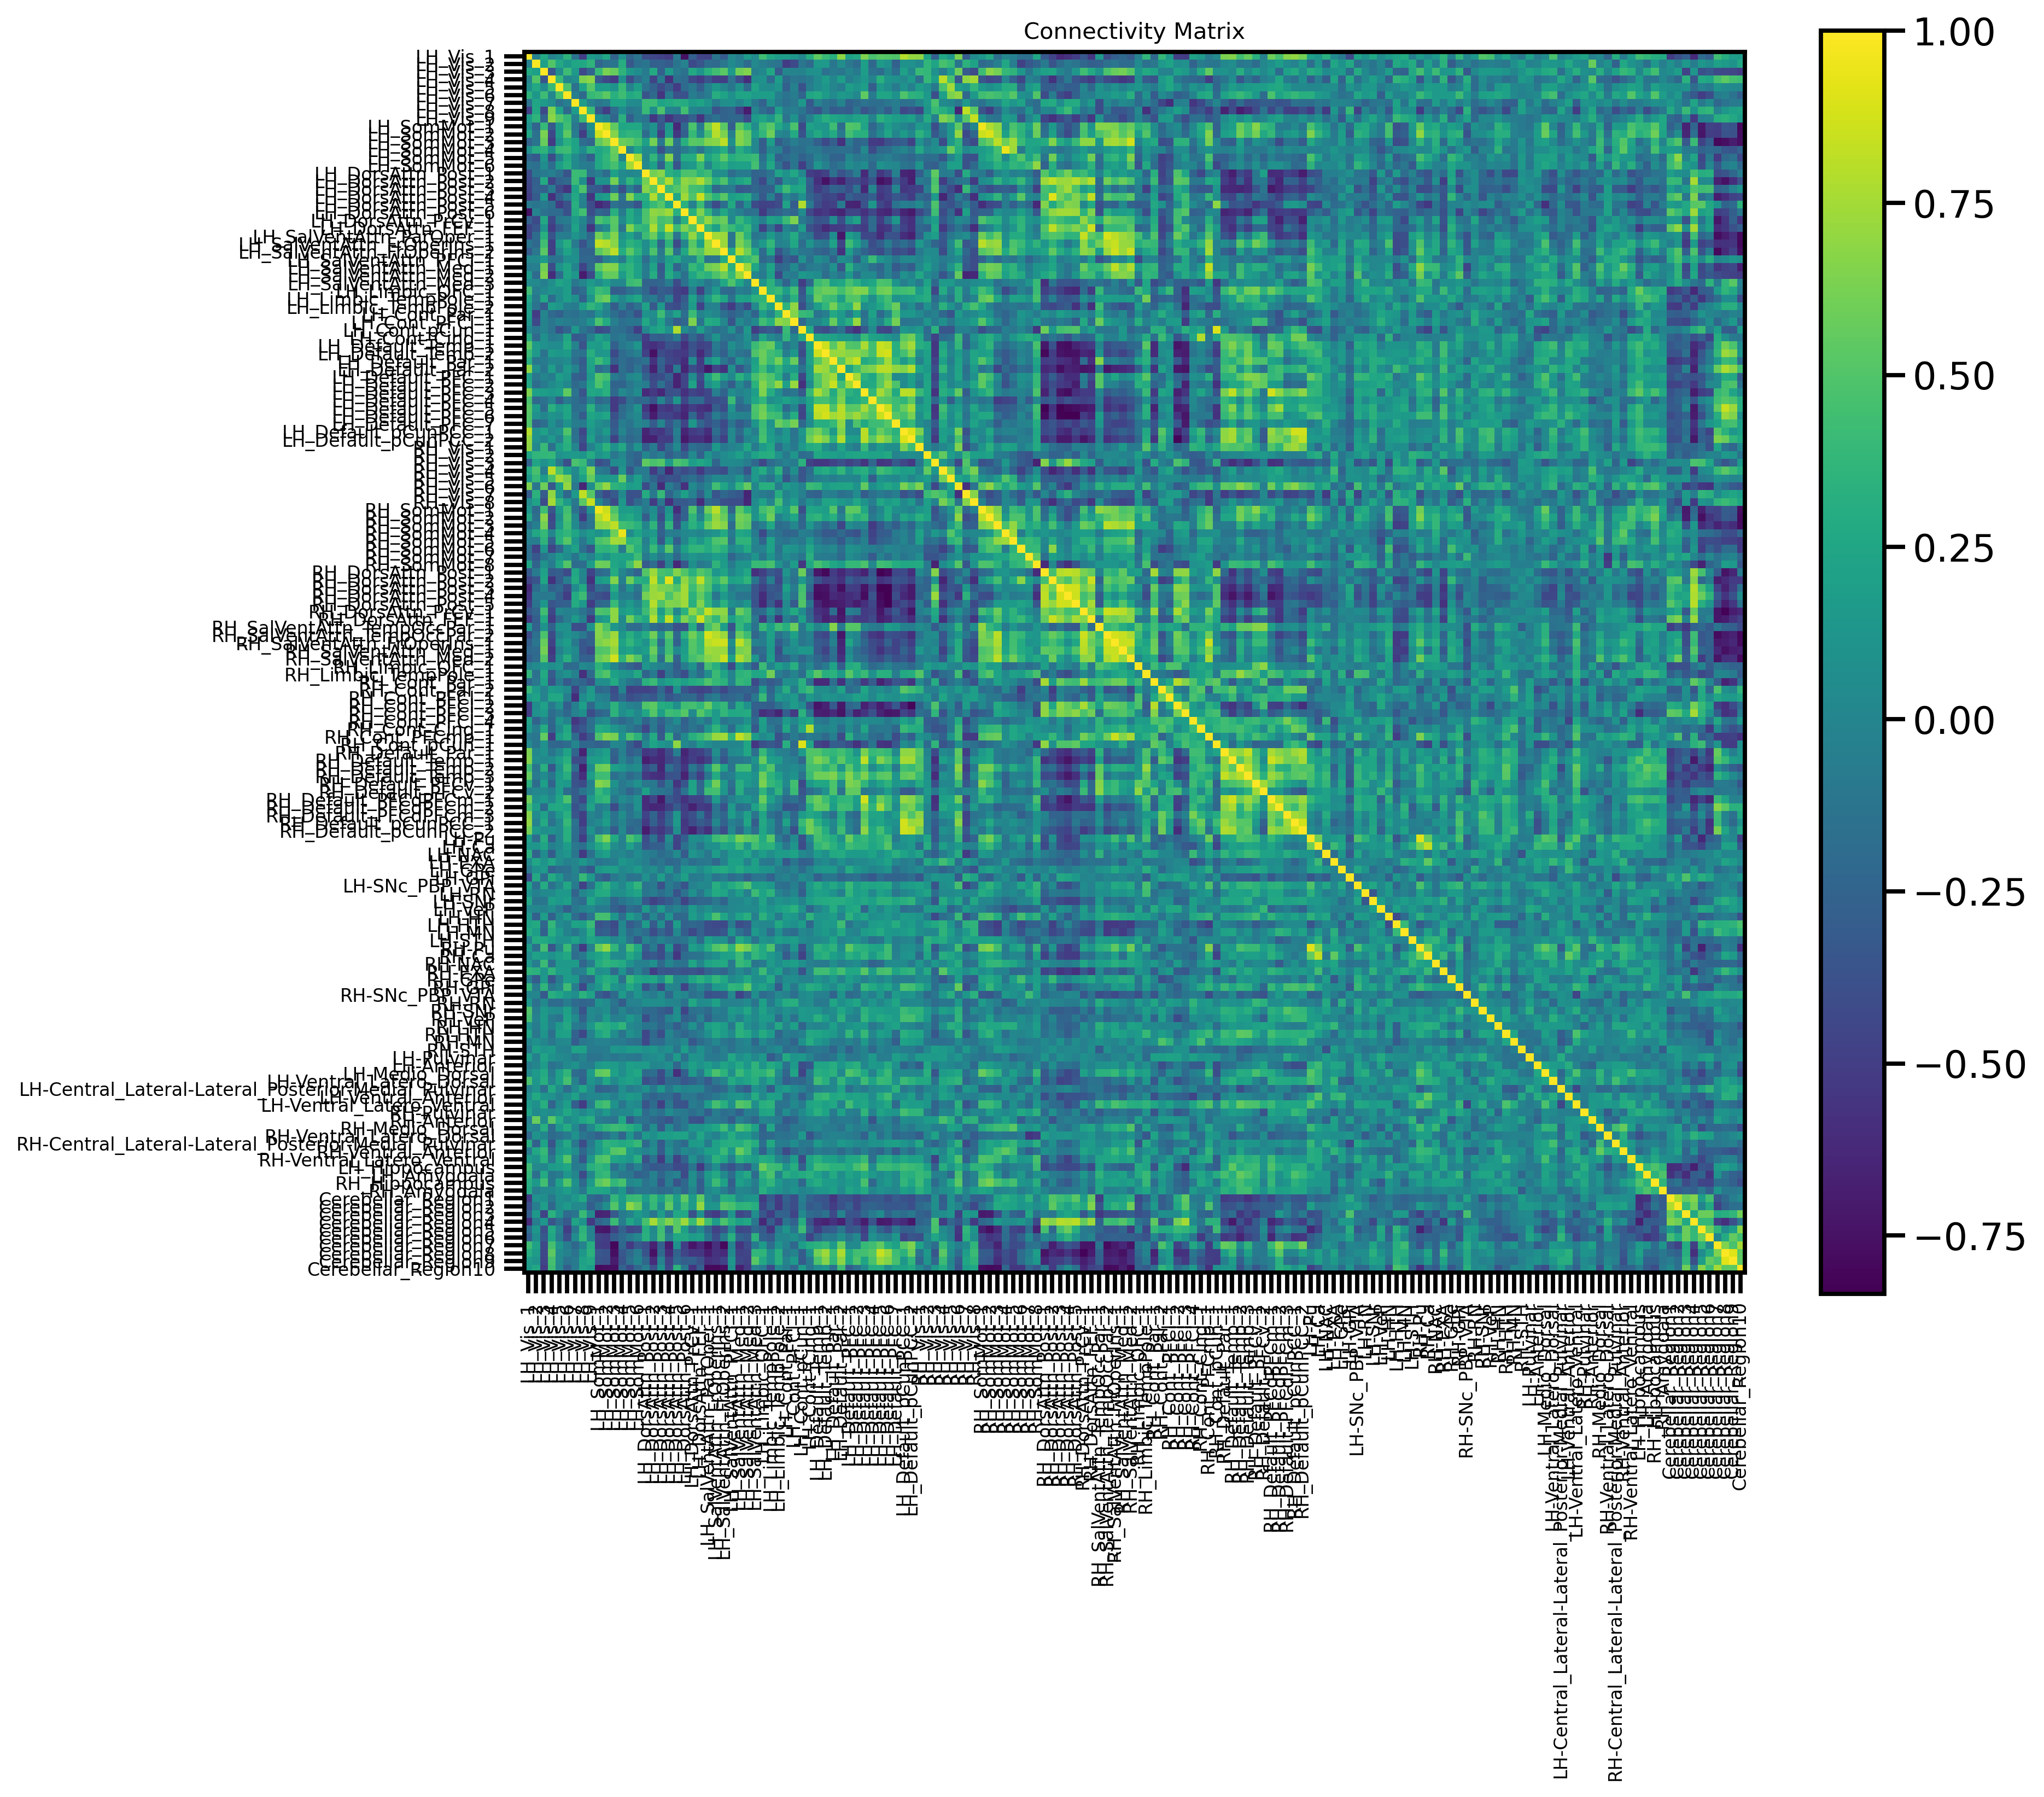

In [9]:
schaef156_atlas_info = UKBB_path + 'atlases/atlas-4S156Parcels/atlas-4S156Parcels_dseg.tsv'
schaef156_labels = pd.read_csv(schaef156_atlas_info, sep='\t')['label'].tolist()
schaef456_atlas_info = UKBB_path + 'atlases/atlas-4S456Parcels/atlas-4S456Parcels_dseg.tsv'
schaef456_labels = pd.read_csv(schaef456_atlas_info, sep='\t')['label'].tolist()

# Randomly select a subject ID
random_subject = random.choice(unique_subject_ids)

# Find the session folder for this subject
atlas_name = '156'

# Select appropriate labels based on atlas name
if atlas_name == '156':
    labels = schaef156_labels
    atlas_str = '4S156Parcels'
elif atlas_name == '456':
    labels = schaef456_labels 
    atlas_str = '4S456Parcels'
else:
    raise ValueError(f"Unsupported atlas_name: {atlas_name}")


subject_dir = os.path.join(UKBB_path, 'XCP_D', f'sub-{random_subject}')
session_dirs = [d for d in os.listdir(subject_dir) if d.startswith('ses-')]

if len(session_dirs) > 0:
    # Take the first session (or could randomly select if multiple sessions exist)
    session = session_dirs[0]
    
    # Construct path to the relmat file
    relmat_path = os.path.join(subject_dir, session, 'func', 
                              f'sub-{random_subject}_{session}_task-rest_space-MNI152NLin6Asym_seg-{atlas_str}_stat-pearsoncorrelation_relmat.tsv')
    
    print(f"Selected subject: {random_subject}")
    print(f"Full path to relmat: {relmat_path}")

schaef_subject_df = pd.read_csv(relmat_path, sep='\t', header=None)
schaef_subject_mat =schaef_subject_df.values[1:, 1:]
schaef_subject_mat = np.array(schaef_subject_mat, dtype=float)

plt.figure(figsize=(12, 10), dpi=200)
plt.imshow(schaef_subject_mat)
plt.colorbar()

plt.figure(figsize=(12, 10), dpi=300)
plt.imshow(schaef_subject_mat)
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90, fontsize=8)
plt.yticks(range(len(labels)), labels, fontsize=8)
plt.title('Connectivity Matrix', fontsize=10)


### QC Evaluation

In [10]:
missing_qc = []
total_subjects = len(unique_subject_ids)
missing_count = 0

for subject_id in unique_subject_ids:
    subject_dir = os.path.join(UKBB_path, 'XCP_D', f'sub-{subject_id}')
    if os.path.exists(subject_dir):
        session_dirs = [d for d in os.listdir(subject_dir) if d.startswith('ses-')]
        
        if session_dirs:
            session = session_dirs[0]
            qc_file = os.path.join(subject_dir, 'figures', 
                                 f'sub-{subject_id}_{session}_task-rest_space-MNI152NLin6Asym_desc-qualitycontrol_bold.html')
            
            if not os.path.exists(qc_file):
                missing_qc.append(subject_id)
                missing_count += 1

print(f"Total subjects: {total_subjects}")
print(f"Missing QC files: {missing_count} ({(missing_count/total_subjects)*100:.2f}%)")
print("\nSubjects missing QC files:")
print(missing_qc)

# Some subjects seem to be missing BOLD altogether

Total subjects: 1959
Missing QC files: 142 (7.25%)

Subjects missing QC files:
['1010341', '1156032', '1218600', '1204949', '1071768', '1046361', '1126591', '1161438', '1004051', '1143191', '1023101', '1122033', '1038914', '1094000', '1109510', '1217623', '1038880', '1136919', '1208550', '1074529', '1095386', '1129902', '1217525', '1102248', '1203821', '1183856', '1168992', '1217218', '1130588', '1203999', '1078848', '1206170', '1166644', '1172771', '1165663', '1180724', '1111841', '1137930', '1173810', '1089079', '1098549', '1066616', '1185158', '1103909', '1083301', '1079086', '1158512', '1152791', '1062960', '1180151', '1167458', '1184446', '1065163', '1078725', '1030993', '1041228', '1145423', '1095973', '1118577', '1190655', '1106984', '1149954', '1107050', '1036060', '1123327', '1176545', '1204468', '1034067', '1190081', '1172524', '1148052', '1190323', '1062142', '1141208', '1203268', '1200264', '1080018', '1034001', '1065821', '1000598', '1101253', '1181192', '1022915', '100681

In [11]:
from bs4 import BeautifulSoup
import pandas as pd
import os

def extract_qc_metrics(html_content):
    """Extract QC metrics from HTML content."""
    soup = BeautifulSoup(html_content, 'html.parser')
    metrics = {}
    
    # Find the ul element with class 'elem-desc'
    ul_elem = soup.find('ul', class_='elem-desc')
    if ul_elem:
        for li in ul_elem.find_all('li'):
            text = li.get_text().strip()
            # Split on ':' and clean up the key-value pairs
            if ':' in text:
                key, value = text.split(':', 1)
                key = key.strip()
                value = value.strip()
                
                # Handle the special case of correlation metrics
                if 'Before and After Processing' in key:
                    before, after = value.split(',')
                    key_base = key.replace('Before and After Processing', '').strip()
                    metrics[f"{key_base}_Before"] = float(before)
                    metrics[f"{key_base}_After"] = float(after)
                else:
                    # Try to convert to float if possible
                    try:
                        metrics[key] = float(value)
                    except ValueError:
                        metrics[key] = value
    
    return metrics

# Create empty list to store all subject data
all_subjects_data = []

# Iterate through all subjects
for subject_id in unique_subject_ids:
    subject_dir = os.path.join(UKBB_path, 'XCP_D', f'sub-{subject_id}')
    if os.path.exists(subject_dir):
        session_dirs = [d for d in os.listdir(subject_dir) if d.startswith('ses-')]
        
        if session_dirs:
            session = session_dirs[0]  # Take first session
            qc_file = os.path.join(subject_dir, 'figures', 
                                 f'sub-{subject_id}_{session}_task-rest_space-MNI152NLin6Asym_desc-qualitycontrol_bold.html')
            
            if os.path.exists(qc_file):
                with open(qc_file, 'r') as f:
                    html_content = f.read()
                
                # Extract metrics and add subject_id
                metrics = extract_qc_metrics(html_content)
                metrics['subject_id'] = subject_id
                all_subjects_data.append(metrics)

# Create DataFrame
QC_df = pd.DataFrame(all_subjects_data)
# Set subject_id as index
QC_df.set_index('subject_id', inplace=True)

# Display first few rows
print("QC DF shape:", QC_df.shape)
QC_df.head()

QC DF shape: (1817, 10)


,BOLD volume space,Repetition Time (TR),Mean Framewise Displacement,Mean Relative RMS Motion,Max Relative RMS Motion,DVARS_Before,DVARS_After,Correlation between DVARS and FD_Before,Correlation between DVARS and FD_After,Number of Volumes Censored
subject_id,,,,,,,,,,
1076893,MNI152NLin6Asym,0.735,0.2101,0.7706,2.3397,271.8009,20.0026,-0.3519,-0.2121,0.0
1170813,MNI152NLin6Asym,0.735,0.0854,0.4337,0.8207,231.9777,17.9328,-0.2641,-0.1093,0.0
1195827,MNI152NLin6Asym,0.735,0.0728,0.6136,1.1208,211.6140,16.6488,-0.2450,-0.0812,0.0
1164717,MNI152NLin6Asym,0.735,0.0997,0.8954,1.5202,188.8703,17.0263,-0.2241,-0.0049,0.0
1158854,MNI152NLin6Asym,0.735,0.0710,0.2949,0.5529,197.8649,15.4447,-0.2435,-0.1678,0.0


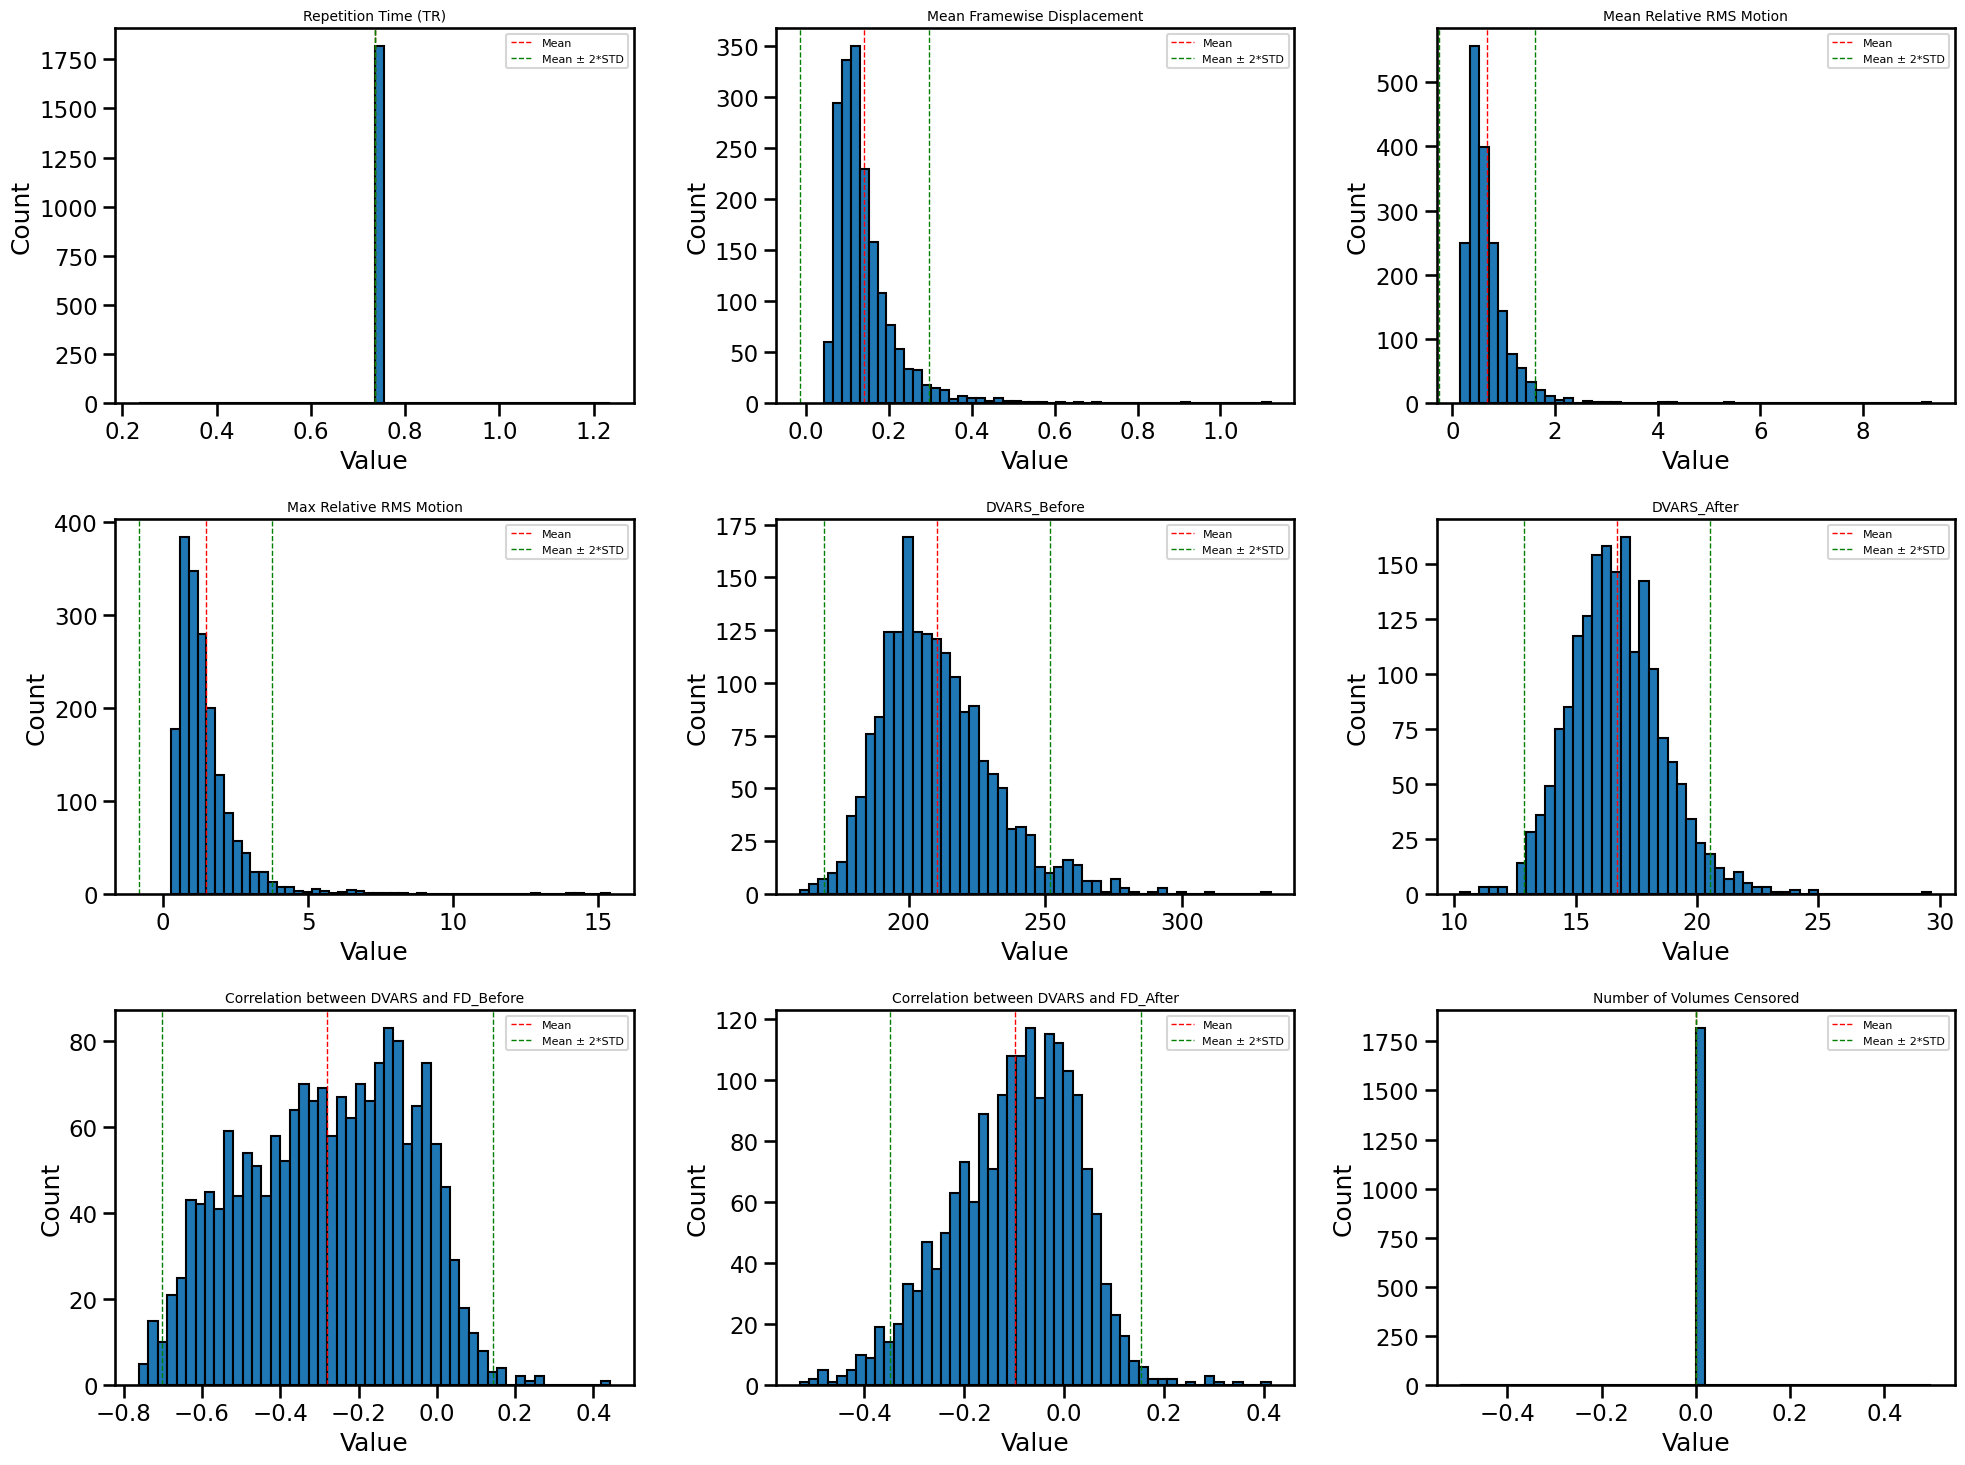


Summary Statistics:
       Repetition Time (TR)  Mean Framewise Displacement  \
count              1817.000                  1817.000000   
mean                  0.735                     0.139701   
std                   0.000                     0.077866   
min                   0.735                     0.042600   
25%                   0.735                     0.092000   
50%                   0.735                     0.120000   
75%                   0.735                     0.160600   
max                   0.735                     1.121600   

       Mean Relative RMS Motion  Max Relative RMS Motion  DVARS_Before  \
count               1817.000000              1817.000000   1817.000000   
mean                   0.676267                 1.467192    210.255955   
std                    0.463693                 1.146392     20.652779   
min                    0.155400                 0.287200    160.204800   
25%                    0.409500                 0.812300    195.9746

In [12]:
# Create a figure with subplots for each QC metric
plt.figure(figsize=(20, 15))

# Get numerical columns (excluding 'BOLD volume space' and 'Repetition Time')
numeric_cols = QC_df.select_dtypes(include=['float64', 'int64']).columns

# Create subplots in a 3x3 grid (8 plots total)
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, idx)
    
    # Create histogram
    plt.hist(QC_df[col].dropna(), bins=50, edgecolor='black')
    plt.title(f'{col}', fontsize=10)
    plt.xlabel('Value')
    plt.ylabel('Count')
    
    # Add vertical lines for mean and mean ± 2*std
    mean = QC_df[col].mean()
    std = QC_df[col].std()
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(mean + 2*std, color='g', linestyle='dashed', linewidth=1, label='Mean ± 2*STD')
    plt.axvline(mean - 2*std, color='g', linestyle='dashed', linewidth=1)
    
    # Add legend
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(QC_df[numeric_cols].describe())

# metric interpretation: https://mriqc.readthedocs.io/en/latest/iqms/bold.html

In [13]:
# Get all subjects that exceed 2 SD for any measure
outlier_subjects = set()  # Using set to avoid duplicates
numeric_cols = QC_df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    mean = QC_df[col].mean()
    std = QC_df[col].std()
    outliers = QC_df[col][(QC_df[col] > mean + 2*std) | (QC_df[col] < mean - 2*std)].index
    outlier_subjects.update(outliers)

# Convert to list and sort for easier viewing
outlier_subjects = sorted(list(outlier_subjects))

# Calculate statistics
total_subjects = len(QC_df)
n_outliers = len(outlier_subjects)
remaining_subjects = total_subjects - n_outliers

print(f"Original sample size: {total_subjects}")
print(f"Number of outlier subjects: {n_outliers} ({(n_outliers/total_subjects)*100:.2f}%)")
print(f"Remaining sample size: {remaining_subjects}")

# Create new DataFrame without outliers
QC_df_clean = QC_df.drop(outlier_subjects)

# Store subjects in lists
subjects_all = sorted(list(QC_df.index))
subjects_clean = sorted(list(QC_df_clean.index))
print(subjects_all)

Original sample size: 1817
Number of outlier subjects: 316 (17.39%)
Remaining sample size: 1501
['1000038', '1000108', '1000149', '1000201', '1000213', '1000267', '1000634', '1000957', '1001083', '1001333', '1001626', '1001710', '1001828', '1001863', '1001890', '1002050', '1002220', '1002264', '1002338', '1002389', '1002490', '1002618', '1002831', '1002840', '1003052', '1003137', '1003196', '1003203', '1003269', '1003287', '1003291', '1003508', '1003582', '1003594', '1003609', '1003780', '1003947', '1004193', '1004214', '1004545', '1004581', '1004837', '1004955', '1005126', '1005167', '1005208', '1005483', '1005497', '1005591', '1005643', '1005729', '1005737', '1005938', '1005961', '1006134', '1006279', '1006335', '1006461', '1006747', '1006764', '1006839', '1006980', '1007010', '1007035', '1007147', '1007209', '1007341', '1007494', '1007943', '1007950', '1008401', '1008426', '1008480', '1008668', '1008792', '1008945', '1009026', '1009116', '1009219', '1009234', '1009263', '1009327', '

In [27]:
def compute_population_average_connectome(subject_list, data_path, atlas_name='156', verbose=True):
    """
    Compute population average connectome from a list of subjects.
    
    Parameters
    ----------
    subject_list : list
        List of subject IDs
    data_path : str
        Path to data directory
    atlas_name : str, optional
        Atlas to use ('156' or '456'), by default '156'
    verbose : bool, optional
        Whether to print progress, by default True
        
    Returns
    -------
    tuple
        (population average connectome matrix,
         number of subjects skipped,
         number of connectomes with NaN values)
    """
    # Validate atlas name
    atlas_str = '4S156Parcels' if atlas_name == '156' else '4S456Parcels' if atlas_name == '456' else None
    if not atlas_str:
        raise ValueError(f"Unsupported atlas_name: {atlas_name}")

    # Initialize list to store connectomes
    connectomes = []
    n_skipped = 0

    # Collect all valid connectomes
    for i, subject_id in enumerate(subject_list):
        if verbose and i % 100 == 0:
            print(f"Loading subject {i}/{len(subject_list)}")
            
        # Get subject path
        subject_dir = os.path.join(data_path, 'XCP_D', f'sub-{subject_id}')
        if not os.path.exists(subject_dir):
            n_skipped += 1
            continue
            
        # Get session
        session_dirs = [d for d in os.listdir(subject_dir) if d.startswith('ses-')]
        if not session_dirs:
            n_skipped += 1
            continue
            
        # Get connectome path
        relmat_path = os.path.join(subject_dir, session_dirs[0], 'func',
            f'sub-{subject_id}_{session_dirs[0]}_task-rest_space-MNI152NLin6Asym_seg-{atlas_str}_stat-pearsoncorrelation_relmat.tsv')
        
        try:
            # Load connectome
            curr_mat = pd.read_csv(relmat_path, sep='\t', header=None).values[1:, 1:].astype(float)
            connectomes.append(curr_mat)
        except Exception as e:
            if verbose: 
                print(f"Error processing subject {subject_id}: {str(e)}")
            n_skipped += 1
            continue

    # Count connectomes with NaN values
    nan_count = sum(np.any(np.isnan(conn)) for conn in connectomes)
    if verbose:
        print(f"Number of connectomes with NaN values: {nan_count} out of {len(connectomes)} total connectomes")

    # Compute average
    pop_avg = np.nanmean(connectomes, axis=0)
    # pop_avg = np.mean(connectomes, axis=0) # drops any region with NaN
    
    return pop_avg, connectomes
UKBB_S156_connectome_mu, S156_connectomes = compute_population_average_connectome(
    subject_list=subjects_all,
    atlas_name='156',
    data_path=UKBB_path
)

Loading subject 0/1817
Loading subject 100/1817
Loading subject 200/1817
Error processing subject 1030376: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1030376/ses-20227/func/sub-1030376_ses-20227_task-rest_space-MNI152NLin6Asym_seg-4S156Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 300/1817
Error processing subject 1035201: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1035201/ses-20227/func/sub-1035201_ses-20227_task-rest_space-MNI152NLin6Asym_seg-4S156Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 400/1817
Loading subject 500/1817
Loading subject 600/1817
Loading subject 700/1817
Loading subject 800/1817
Loading subject 900/1817
Loading subject 1000/1817
Error processing subject 1135018: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/XCP_D/sub-1135018/ses-20227/func/su

### Comparison to HCP ENIGMA functional connectome

In [31]:
hcp_cortical_connectome = load_connectome(measure='FC', omit_subcortical=True)
hcp_cortical_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()[:100]
ukbb_cortical_connectome = UKBB_S156_connectome_mu[:100, :100]
ukbb_cortical_labels = pd.read_csv(schaef156_atlas_info, sep='\t')['label_7network'].tolist()[:100]

#### HCP cortical connectome

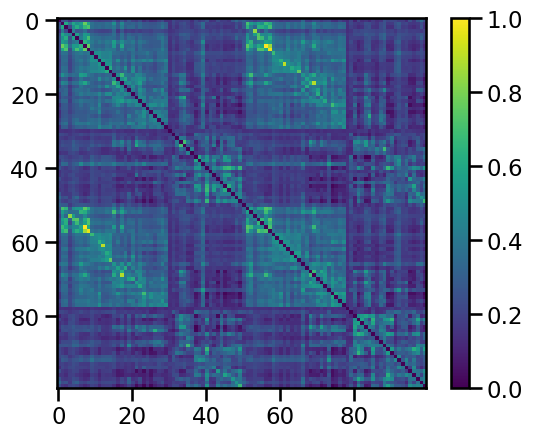

In [32]:
plt.imshow(hcp_cortical_connectome)
plt.colorbar()


#### UKBB cortical connectome

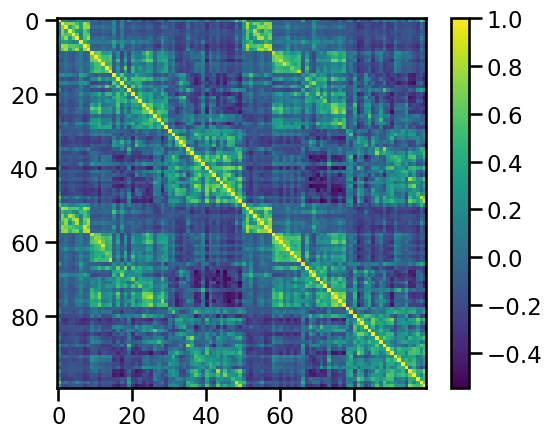

In [33]:
plt.imshow(ukbb_cortical_connectome)
plt.colorbar()


In [34]:
# Flatten the connectivity matrices to 1D arrays for correlation analysis
hcp_flat = hcp_cortical_connectome.flatten()
ukbb_flat = ukbb_cortical_connectome.flatten()

# Calculate Pearson correlation
pearson_corr = np.corrcoef(hcp_flat, ukbb_flat)[0,1]

# Calculate Spearman correlation 
spearman_corr = spearmanr(hcp_flat, ukbb_flat)[0]

print(f"Pearson correlation between HCP and UKBB cortical connectomes: {pearson_corr:.3f}")
print(f"Spearman correlation between HCP and UKBB cortical connectomes: {spearman_corr:.3f}")


Pearson correlation between HCP and UKBB cortical connectomes: 0.648
Spearman correlation between HCP and UKBB cortical connectomes: 0.690


Spearman correlation between HCP and UKBB cortical connectomes (negative values zeroed): 0.614


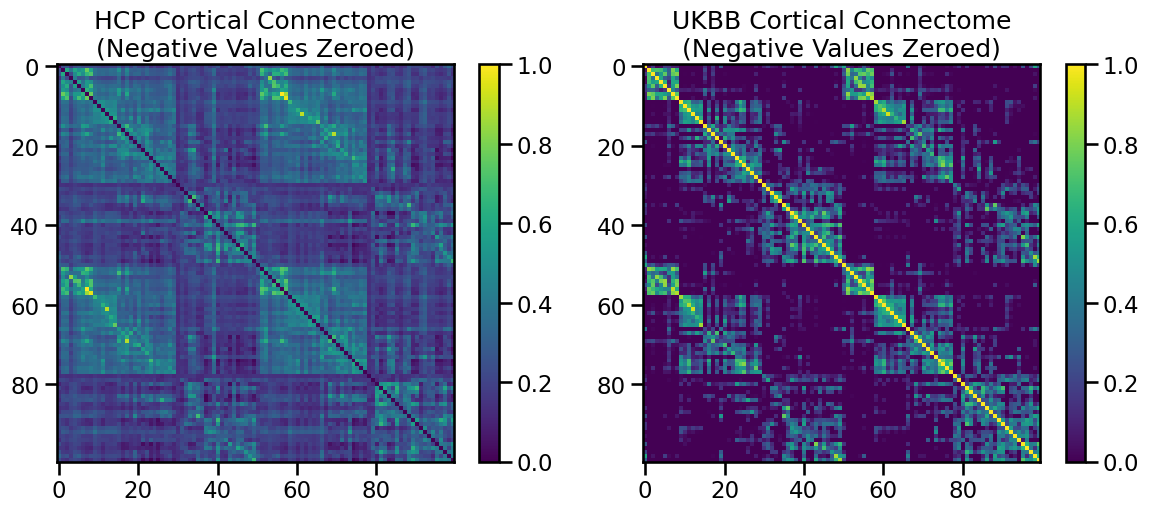

In [35]:
# Create copies and zero out negative values
hcp_nonneg = hcp_cortical_connectome.copy()
ukbb_nonneg = ukbb_cortical_connectome.copy()
hcp_nonneg[hcp_nonneg < 0] = 0
ukbb_nonneg[ukbb_nonneg < 0] = 0

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(hcp_nonneg)
ax1.set_title('HCP Cortical Connectome\n(Negative Values Zeroed)')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(ukbb_nonneg)
ax2.set_title('UKBB Cortical Connectome\n(Negative Values Zeroed)') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()

# Calculate Spearman correlation between the non-negative matrices
spearman_nonneg = spearmanr(hcp_nonneg.flatten(), ukbb_nonneg.flatten())[0]
print(f"Spearman correlation between HCP and UKBB cortical connectomes (negative values zeroed): {spearman_nonneg:.3f}")

